# CNN을 활용한 MNIST이미지 분류

## #01. 패키지 준비하기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import datetime as dt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets.mnist import load_data

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

## #02. 데이터 셋 준비하기

In [2]:
(x_train, y_train), (x_test, y_test) = load_data(path='mnist_npz')

11490434/11490434 [==============================] - 4s 0us/step


## #03. 데이터 전처리
결측치 등의 데이터 이상점이 없는 예제 데이터이므로 생략

## #04. 탐색적 데이터 분석
### 임의의 샘플 데이터 확인

In [12]:
print(x_train[1])
print(np.max(x_train[1]))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  51 159 253
  159  50   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  48 238 252 252
  252 237   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  54 227 253 252 239
  233 252  57   6   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  10  60 224 252 253 252 202
   84 252 253 122   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 163 252 252 252 25

In [13]:
for i in x_train[1]:
    for j in i:
        print("%03d" % j, end="")
    print()

000000000000000000000000000000000000000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000051159253159050000000000000000000000000
000000000000000000000000000000000000000000048238252252252237000000000000000000000000
000000000000000000000000000000000000000054227253252239233252057006000000000000000000
000000000000000000000000000000000010060224252253252202084252253122000000000000000000
000000000000000000000000000000000163252252252253252252096189253167000000000000000000
000000000000000000000000000000051238253253190114253228047079255168000000000000000000
000000000000000000000000000048238252252179012075121021000000253243050000000000000000
00000000000000000000000003816525323320808400000000000000000025325

In [14]:
print(y_train[1])

0


### 데이터 그려보기
mnist 데이터셋은 0~9까지 가로28px, 세로28px 크기의 이미지 60000장 + 10000장 데이터.

글자를 표현하는 간단한 이미지이므로 배경색을 단색으로 처리하고 글자가 표시되는 영역의 색상을 노란색으로 표현.

색상값은 0~255 사이의 10진 정수.

그러므로 이미지 데이터들은 이미지 픽셀 크기 만큼의 2차 배열의 각 원소가 색상값을 의미하는 숫자로 구성된 데이터로 표현가능

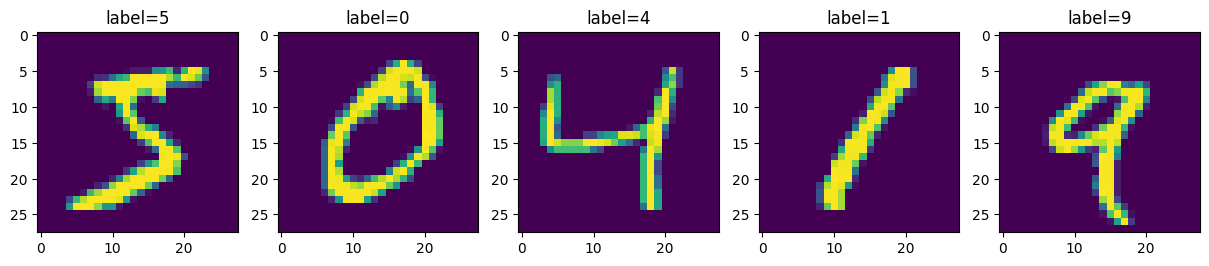

In [15]:
fig, ax = plt.subplots(1,5, figsize=(15,3), dpi=100)

for i in range(0, len(ax)):
    train = x_train[i]
    label = y_train[i]
    ax[i].imshow(train)
    ax[i].set_title('label=%d' % label)

plt.show()
plt.close()

## #05. 데이터셋 분리
### 랜덤시드 고정

In [17]:
np.random.seed(777)

### 훈련데이터와 레이블 구분하기
처음부터 데이터 셋이 구분되어 있으므로 생략

### 훈련데이터와 검증데이터로 분할
처음부터 데이터 셋이 구분되어 있으므로 생략

### 종속변수(레이블)에 대한 one-hot-encoding

In [18]:
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
print(y_test_one_hot)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### 훈련, 검증용 독립변수(이미지)의 차수 재설정
기본 CNN 골격에 맞게 28 X 28 X 1로 차원(3차원) 변경

In [19]:
x_train.shape

(60000, 28, 28)

> 기존은 2차원 배열의 이미지임

In [20]:
x_train_reshape = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test_reshape = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

print(f'훈련 데이터 {x_train_reshape.shape} / 검증 데이터 {x_test_reshape.shape}')

훈련 데이터 (60000, 28, 28, 1) / 검증 데이터 (10000, 28, 28, 1)


### 이미지 데이터 정규화
이미지와 같이 복잡한 데이터의 경우 BatchNormalization(Vector화)층을 적용하여 텐서플로우 모델 구성시 표준화를 수행하는 학습층을 추가할 수 있다.

그 경우 독립변수 데이터를 직접 표준화 할 필요가 없다.

## #06. 모델 생성
### 모델 정의

Input image -> (1) Convolution ->['BatchNormalization']-> (2) Max Pooling -> (3) Convolution -> (4) Max Pooling -> (5) Flatten -> (6) Fully-Connected Layers -> (7) Output Image

- **(1) Convolution = Convolution + Activation Function**
    - 영상이나 이미지의 특징을 확인하기 위한 함수
    - `filters`: 필터(커널)의 개수
    - `kernel_size`: 필터의 크기
    - `strides`: 필터의 이동 간격
    - `padding`: valid(패딩 없음), same(인풋과 아웃풋이 같도록 패딩)
    - `activation`: 활성화 함수
    - `input_shape`: 첫 레이어에 인풋으로 들어오는 크기

- **(1)-(2) BatchNormalization (배치 정규화)**
    - 신경망 입력데이터를 평균 0, 분산 1로 정규화해서 학습이 잘 이루어지도록 하는 방법
    - BatchNormalization 층에서 정규화를 수행하므로 별도의 정규화를 적용할 필요가 없다.
    - 만약 이 층을 적용하지 않는다면 학습 전에 별도의 정규화를 수행하는 것이 좋다.

- **(2) Max Pooling**
    - 컨볼루션 레이어의 출력 이미지에서 주요값만 뽑아 크기가 작은 출력 영상을 만든다.
    - `pool_size`: 축소시킬 필터의 크기(비율)
    - `strides`: 필터의 이동 간격. 기본값으로 pool_size를 갖는다.
    - 일반적으로 strides는 pool_size와 동일하게 적용되므로 생략하는 편.



In [22]:
model = Sequential()

#------------------------#
# <1> 
# (1) Convolution
model.add(Conv2D(filters=32, kernel_size=(5, 5), strides=(1,1), padding='same', activation='relu', input_shape=(28,28,1)))
# (1)-(2) BatchNormalization 표준화
model.add(BatchNormalization())
# (2) Maxpooling
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
# 랜덤으로 25%의 뉴런을 쉬게함
model.add(Dropout(0.25))
#-------------------------#
# <2> 이전보다 filter는 크게, kernel_size는 작게, input_shape는 최초에만 적용하므로 여기서는 생략
# (1) Convolution
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'))
# (1)-(2) BatchNormalization 표준화
model.add(BatchNormalization())
# (2) Maxpooling
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
# 랜덤으로 25%의 뉴런을 쉬게함
model.add(Dropout(0.25))
#----------------------------#
# <3>
# 1차원으로 변환하기 위한 Layer --> Dense Layer을 쌓기 전 마지막 처리
model.add(Flatten())
#---------------------------#
# <4>
model.add(Dense(512, activation='relu'))
# 최종 아웃풋의 수는 one_hot_encoding의 원소 수 만큼
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 batch_normalization_1 (Bat  (None, 28, 28, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_2 (Bat  (None, 14, 14, 64)       

### 학습하기

In [23]:
start = dt.datetime.now()

result = model.fit(x_train_reshape, y_train_one_hot, epochs=500, validation_data=(x_test_reshape, y_test_one_hot),
                   callbacks=[EarlyStopping(monitor='val_loss', patience=5, verbose=1),
                              ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, min_lr=0.0001, factor=0.5)])
end = dt.datetime.now()

Epoch 1/500
1875/1875 [==============================] - 60s 32ms/step - loss: 0.1574 - acc: 0.9560 - val_loss: 0.0642 - val_acc: 0.9800 - lr: 0.0010
Epoch 2/500
1875/1875 [==============================] - 64s 34ms/step - loss: 0.0618 - acc: 0.9813 - val_loss: 0.0512 - val_acc: 0.9831 - lr: 0.0010
Epoch 3/500
1875/1875 [==============================] - 65s 35ms/step - loss: 0.0518 - acc: 0.9844 - val_loss: 0.0517 - val_acc: 0.9865 - lr: 0.0010
Epoch 4/500
1875/1875 [==============================] - 67s 36ms/step - loss: 0.0412 - acc: 0.9881 - val_loss: 0.0480 - val_acc: 0.9875 - lr: 0.0010
Epoch 5/500
1875/1875 [==============================] - 68s 37ms/step - loss: 0.0337 - acc: 0.9900 - val_loss: 0.0353 - val_acc: 0.9906 - lr: 0.0010
Epoch 6/500
1875/1875 [==============================] - 68s 36ms/step - loss: 0.0308 - acc: 0.9915 - val_loss: 0.0362 - val_acc: 0.9902 - lr: 0.0010
Epoch 7/500
1875/1875 [==============================] - 72s 38ms/step - loss: 0.0272 - acc: 0.9923 

In [24]:
delta = end - start
delta.seconds

2317

## #07. 학습결과 평가

In [25]:
# 결과 데이터프레임 생성
result_df = pd.DataFrame(result.history)
result_df['epochs'] = result_df.index + 1
result_df

,loss,acc,val_loss,val_acc,lr,epochs
0,0.157387,0.956017,0.064209,0.9800,0.001000,1
1,0.061763,0.981317,0.051234,0.9831,0.001000,2
2,0.051772,0.984383,0.051695,0.9865,0.001000,3
3,0.041186,0.988083,0.048027,0.9875,0.001000,4
4,0.033732,0.989950,0.035342,0.9906,0.001000,5
5,0.030840,0.991450,0.036184,0.9902,0.001000,6
6,0.027186,0.992250,0.058421,0.9860,0.001000,7
7,0.025405,0.992233,0.047567,0.9888,0.001000,8
8,0.010930,0.996250,0.027843,0.9937,0.000500,9
9,0.008858,0.996983,0.029465,0.9938,0.000500,10


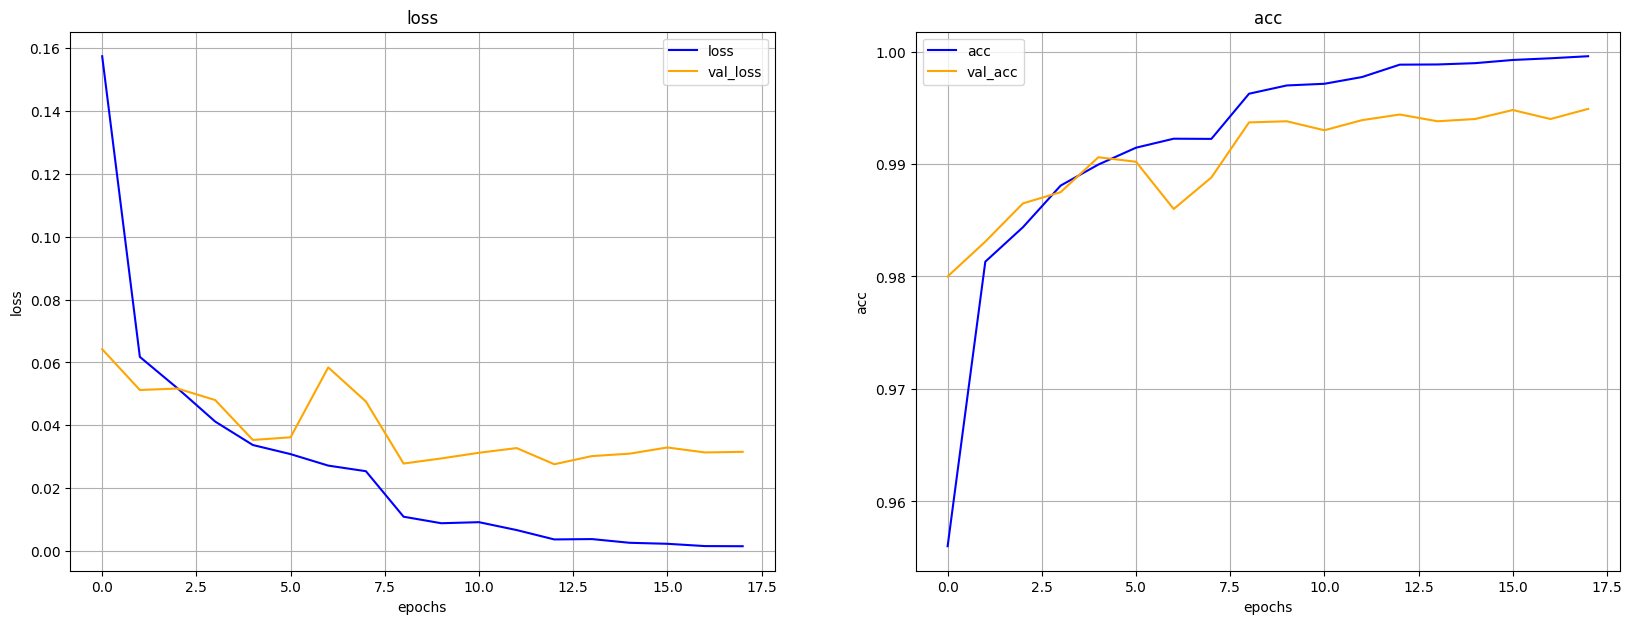

In [26]:
# 손실률과 정확도 시각화
# 학습 결과 그래프의 컬럼명
column_names = result_df.columns

# 학습데이터에 대한 필드이름
train_column_name = [column_names[0], column_names[1]]
# 검증데이터에 대한 필드이름
test_column_name = [column_names[2], column_names[3]]

# 학습 결과 그래프
fig, ax = plt.subplots(1,2, figsize=(20,7))

for i, v in enumerate(ax):
    sb.lineplot(data=result_df, x=result_df.index, y=train_column_name[i], color='blue', label=train_column_name[i], ax=v)
    sb.lineplot(data=result_df, x=result_df.index, y=test_column_name[i], color='orange', label=test_column_name[i], ax=v)
    v.set_title(train_column_name[i])
    v.set_xlabel('epochs')
    v.set_ylabel(train_column_name[i])
    v.grid()
    v.legend()

plt.show()
plt.close()

In [27]:
# 학습 평가
evaluate1 = model.evaluate(x_train_reshape, y_train_one_hot)
print("최종 훈련 손실률: %f, 최종 훈련 정확도: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test_reshape, y_test_one_hot)
print("최종 검증 손실률: %f, 최종 검증 정확도: %f" % (evaluate2[0], evaluate2[1]))

1875/1875 [==============================] - 15s 8ms/step - loss: 7.5324e-05 - acc: 1.0000
최종 훈련 손실률: 0.000075, 최종 훈련 정확도: 0.999983
313/313 [==============================] - 3s 9ms/step - loss: 0.0316 - acc: 0.9949
최종 검증 손실률: 0.031564, 최종 검증 정확도: 0.994900


## #08. 학습결과 적용

### 1) 훈련데이터에 대한 예측 결과 산정

In [28]:
result = model.predict(x_train_reshape)
data_count, case_count = result.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
result[0]

1875/1875 [==============================] - 18s 10ms/step
60000개의 검증 데이터가 10개의 경우의 수를 갖는다.


array([1.9886088e-21, 7.9922965e-17, 1.8484496e-18, 5.8260559e-07,
       1.9826033e-20, 9.9999940e-01, 1.1223626e-15, 1.7663077e-18,
       9.2495363e-17, 2.1762308e-16], dtype=float32)

#### 가장 큰 확률 값의 인덱스를 별도 리스트로 추출

In [29]:
arg_result = np.argmax(result, axis=1)
arg_result

array([5, 0, 4, ..., 5, 6, 8], dtype=int64)

#### 데이터 비교

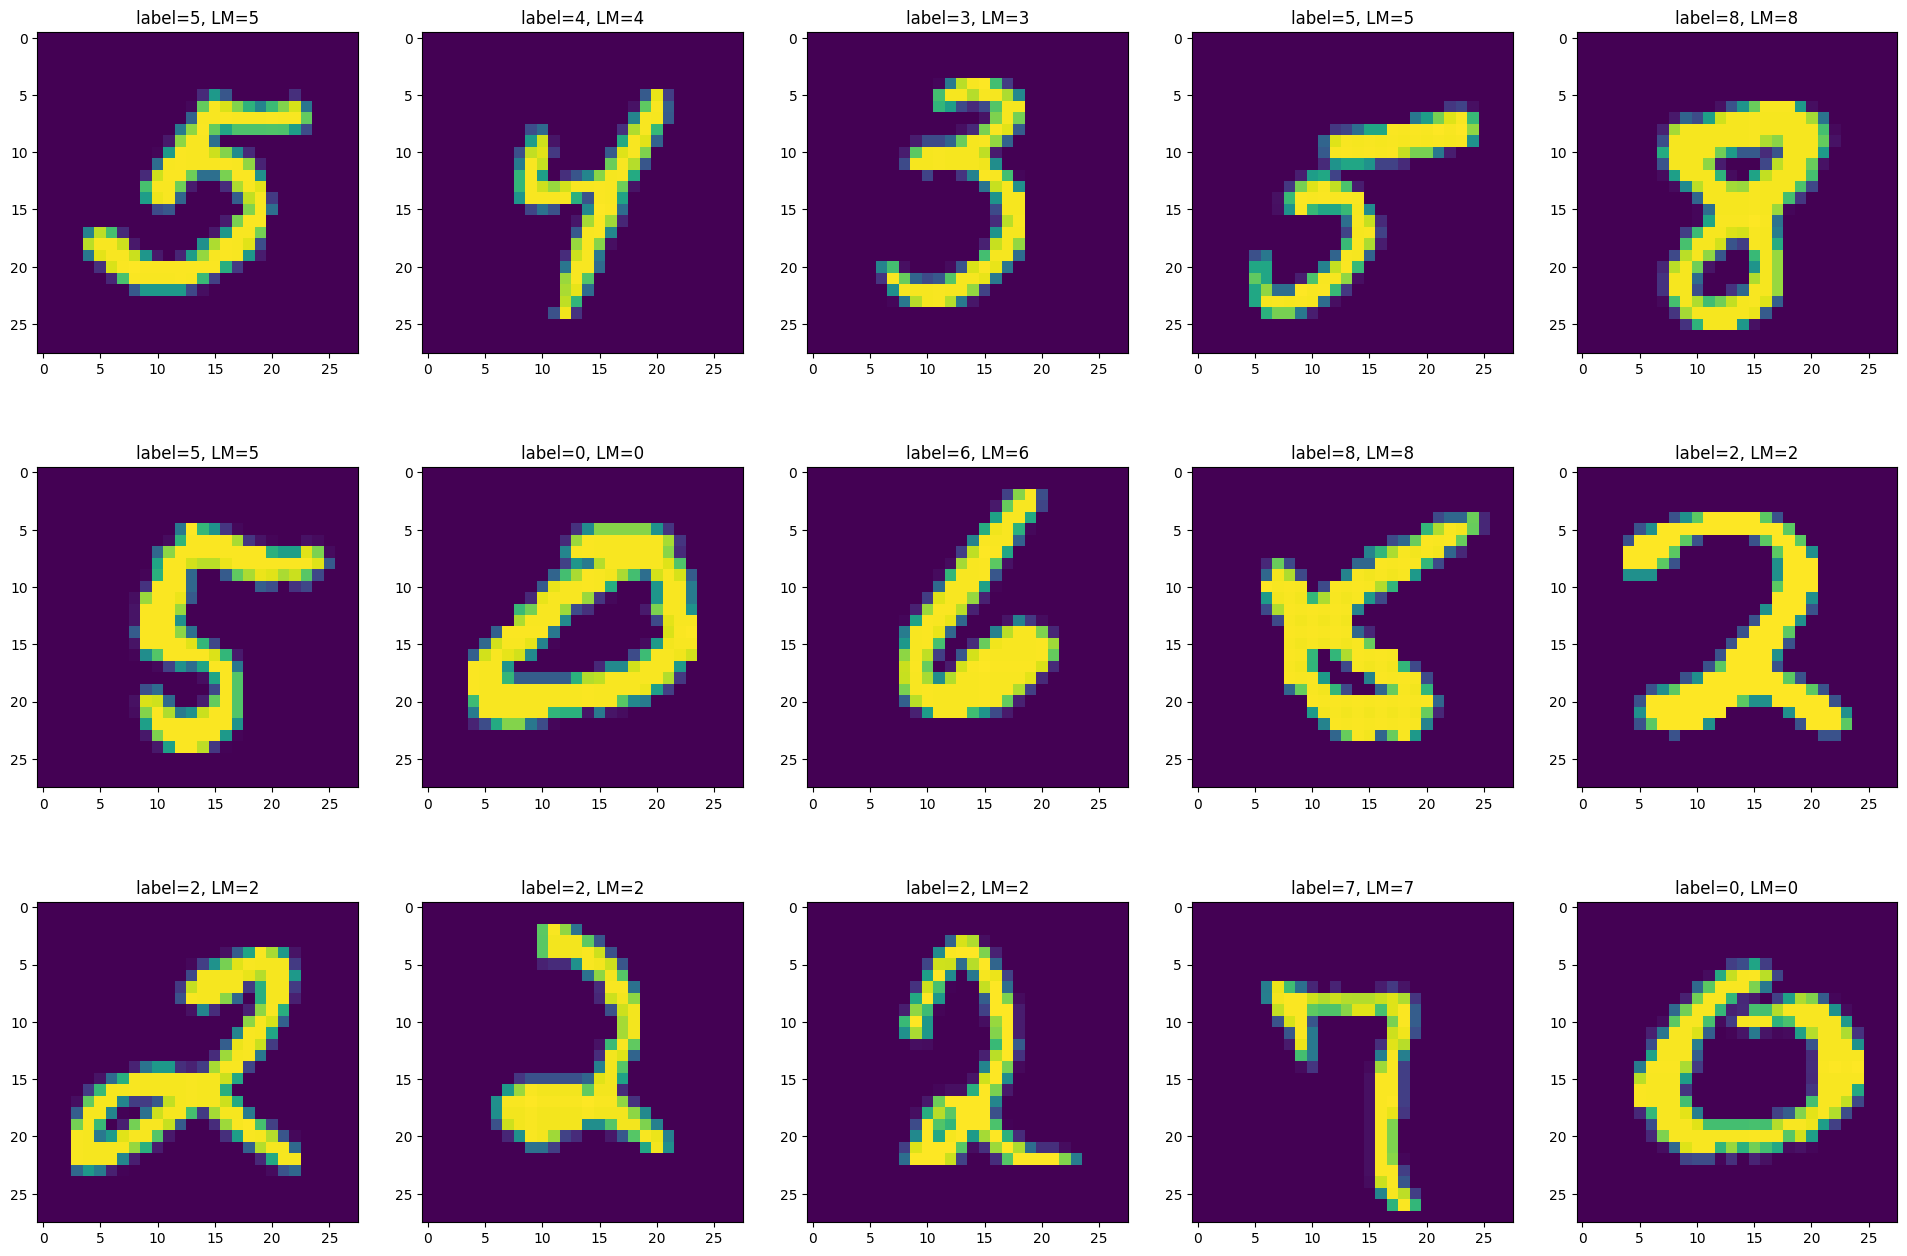

In [31]:
row = 3
col = 5
fig, ax = plt.subplots(row, col, figsize=((col+1)*4, (row+1)*4), dpi=100)

size = row * col
length = len(y_train)

for i in range(0, size):
    k = np.random.randint(length)
    train = x_train[k]
    label = y_train[k]
    ax[i//col][i%col].imshow(train)
    ax[i//col][i%col].set_title("label=%d, LM=%d" % (label, arg_result[k]))

plt.show()
plt.close()

#### 혼동행렬

In [32]:
cm = confusion_matrix(y_train, arg_result)
cmdf2 = pd.DataFrame(cm, columns=list(map(lambda x: "real(%d)" % x, range(10))), index=list(map(lambda x: "predict(%d)" % x, range(10))))
cmdf2

,real(0),real(1),real(2),real(3),real(4),real(5),real(6),real(7),real(8),real(9)
predict(0),5923,0,0,0,0,0,0,0,0,0
predict(1),0,6742,0,0,0,0,0,0,0,0
predict(2),0,0,5958,0,0,0,0,0,0,0
predict(3),0,0,0,6131,0,0,0,0,0,0
predict(4),0,0,0,0,5842,0,0,0,0,0
predict(5),0,0,0,0,0,5421,0,0,0,0
predict(6),0,0,0,0,0,0,5918,0,0,0
predict(7),0,1,0,0,0,0,0,6264,0,0
predict(8),0,0,0,0,0,0,0,0,5851,0
predict(9),0,0,0,0,0,0,0,0,0,5949


#### 혼동행렬 히트맵

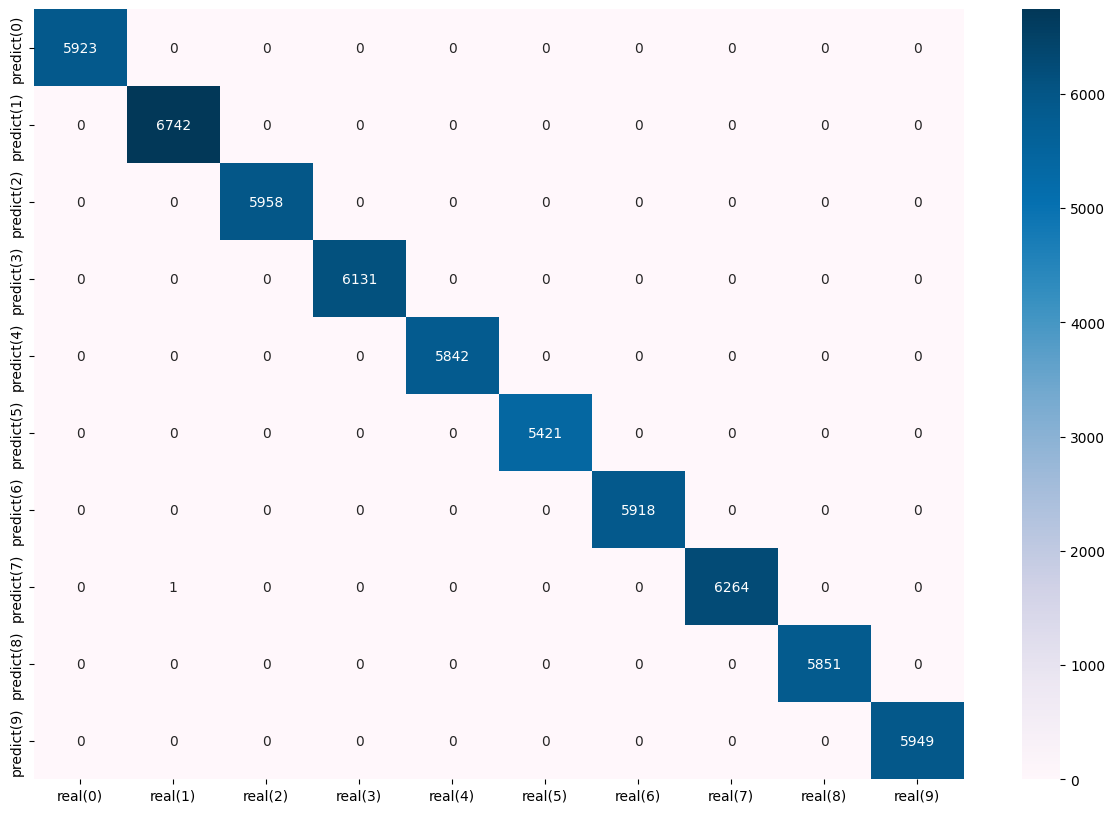

In [33]:
plt.figure(figsize=(15,10))
sb.heatmap(cmdf2, annot=True, fmt='d', cmap='PuBu')
plt.show()
plt.close()